# Model evaluation: BERT (emotion)

---

## Table of Contents

1. [Imports](#imports)
2. [Model loading](#model-loading)
3. [Data loading and tokenization](#data-loading-and-tokenization)
4. [Evaluation](#evaluation)
5. [Report](#report)

# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Model loading

In [2]:
model_path = './bert_emotion_model'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [3]:
device = 'cuda'

model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Data loading and tokenization

In [4]:
base_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
test_file = os.path.join(base_dir, 'test_emotion.csv')
test_data = pd.read_csv(test_file)

In [5]:
class LabeledDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text']
        self.labels = data['label']
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    dataset = LabeledDataset(data, tokenizer, max_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
test_loader = create_data_loader(test_data, tokenizer, max_len=256, batch_size=16)

# Evaluation

In [8]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Report

In [9]:
class_names = ['Smutek', 'Radość', 'Miłość', 'Złość', 'Strach', 'Zaskoczenie']
report = classification_report(all_labels, all_preds, output_dict=True, target_names=class_names)

In [10]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      Smutek       0.99      0.95      0.97      2500
      Radość       0.99      0.92      0.95      2500
      Miłość       0.93      1.00      0.96      2500
       Złość       0.96      0.95      0.95      2500
      Strach       0.93      0.90      0.92      2500
 Zaskoczenie       0.90      1.00      0.95      2206

    accuracy                           0.95     14706
   macro avg       0.95      0.95      0.95     14706
weighted avg       0.95      0.95      0.95     14706



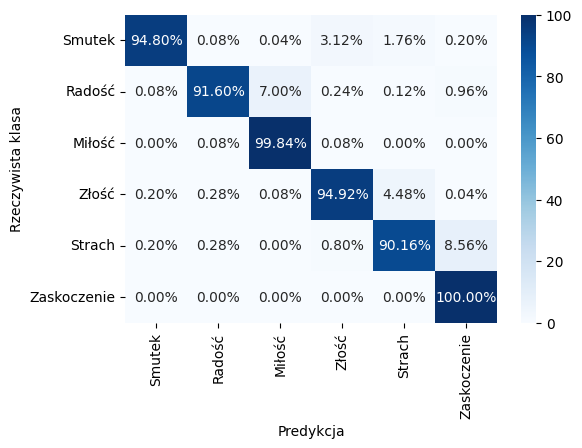

In [11]:
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista klasa")
plt.savefig("cf_mat_bert_emotion.png", dpi=300, bbox_inches='tight', facecolor='white')  
plt.show()

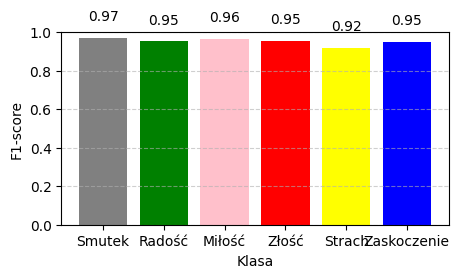

In [16]:

f1_scores = [report[label]['f1-score'] for label in class_names]

plt.figure(figsize=(5, 2.5))
bars = plt.bar(class_names, f1_scores, color=['gray', 'green', 'pink', 'red', 'yellow', 'blue'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.075, f"{yval:.2f}", ha='center', va='bottom')

plt.ylim(0, 1.0)
plt.ylabel('F1-score')
plt.xlabel('Klasa')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("f1_bar_bert_emotion.png", dpi=300, bbox_inches='tight', facecolor='white')  
plt.show()